In [4]:
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely.geometry
import shapely
import pandas as pd
import numpy as np
import random

In [5]:
pol = gpd.read_file("data/IPUMSI_world_release2024.shp")
pol

,OBJECTID,CNTRY_NAME,CNTRY_CODE,BPL_CODE,geometry
0,1,Algeria,012,13010.0,"MULTIPOLYGON (((-2.05592 35.0737, -2.05675 35...."
1,2,Angola,024,12010.0,"MULTIPOLYGON (((12.7976 -4.41685, 12.79875 -4...."
2,3,In dispute South Sudan/Sudan,9999,99999.0,"POLYGON ((28.08408 9.34722, 28.03889 9.34722, ..."
3,4,Benin,204,15010.0,"MULTIPOLYGON (((1.93753 6.30122, 1.93422 6.299..."
4,5,Botswana,072,14010.0,"POLYGON ((25.16312 -17.77816, 25.16383 -17.778..."
...,...,...,...,...,...
280,282,In dispute Brazil/Uruguay,9999,99999.0,"POLYGON ((-57.60586 -30.18462, -57.613 -30.189..."
281,283,Uruguay,858,23130.0,"MULTIPOLYGON (((-54.97583 -34.95042, -54.97336..."
282,284,Venezuela,862,23140.0,"MULTIPOLYGON (((-60.85136 8.60661, -60.85506 8..."
283,55,In dispute Egypt/Sudan,9999,99999.0,"MULTIPOLYGON (((36.8825 22.10042, 36.87753 22...."


In [6]:
geo = gpd.read_file("data/bh326sc0899.shp")
geo.head()

,scalerank,featurecla,name,namealt,region,subregion,geometry
0,7.0,Island,Pentecost,None,Oceania,Melanesia,"POLYGON ((168.22657 -15.98968, 168.20411 -15.9..."
1,7.0,Island,Anatom,None,Oceania,Melanesia,"POLYGON ((169.8379 -20.24737, 169.82997 -20.25..."
2,7.0,Island,Gaua,None,Oceania,Melanesia,"POLYGON ((167.52491 -14.14214, 167.58619 -14.1..."
3,7.0,Island,Utupua,None,Oceania,Melanesia,"POLYGON ((166.52223 -11.27068, 166.52711 -11.2..."
4,7.0,Island,Vanikolo,None,Oceania,Melanesia,"POLYGON ((166.93263 -11.66021, 166.91822 -11.6..."


In [7]:
coast = gpd.read_file("data/ne_50m_coastline.shp")
coast.head()

,scalerank,featurecla,geometry
0,0,Coastline,"LINESTRING (180 -16.15293, 179.84814 -16.21426..."
1,0,Coastline,"LINESTRING (177.25752 -17.0542, 177.2874 -17.0..."
2,0,Coastline,"LINESTRING (127.37266 0.79131, 127.35381 0.847..."
3,0,Coastline,"LINESTRING (-81.32231 24.68506, -81.42007 24.7..."
4,0,Coastline,"LINESTRING (-80.79941 24.84629, -80.83887 24.8..."


<Axes: >

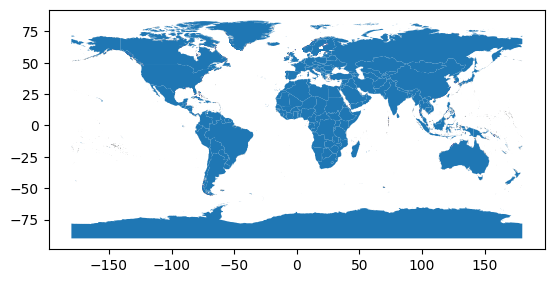

In [8]:
pol.plot()

<Axes: >

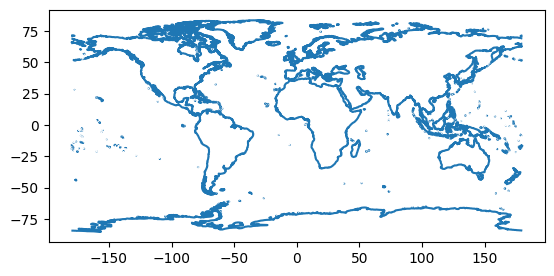

In [9]:
coast.plot()

<Axes: >

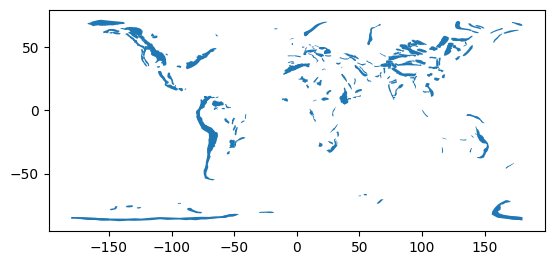

In [10]:
mountains = geo[geo['featurecla'] == "Range/mtn"]
mountains.plot()

<Axes: >

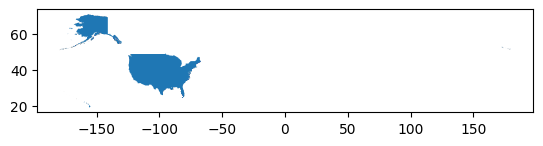

In [11]:
us = pol[pol['CNTRY_NAME'] == "United States"]
us.plot()

Using US because it is familiar

In [12]:
us.head()

,OBJECTID,CNTRY_NAME,CNTRY_CODE,BPL_CODE,geometry
223,225,United States,840,24040.0,"MULTIPOLYGON (((-155.98084 70.91304, -155.9881..."


In [36]:
def to_border(country):
    ret = gpd.GeoSeries(
        country['geometry']
        .apply(
            lambda g: [g]
            if isinstance(g, shapely.geometry.Polygon)
            else [p for p in g.geoms]
        )
        .apply(
            lambda l: [
                shapely.geometry.LineString([c1, c2])
                for p in l
                for c1, c2 in zip(p.exterior.coords, list(p.exterior.coords)[1:])
            ]
        )
        .explode()
    )
    return ret

def country_simplify(country):
    polies = country.explode()
    polies = polies[polies.to_crs(epsg=3395).area > 1000000000]
    polies = polies.simplify(tolerance=0.1)
    country.loc[:, 'geometry'] = shapely.geometry.MultiPolygon(polies.values)
    return country

def get_country(name):
    country = pol[pol['CNTRY_NAME'] == name]
    polies = country_simplify(country)
    border = to_border(polies)
    return gpd.GeoDataFrame([[name, seg] for seg in border], columns=['country', 'geometry'])

In [14]:
# a.empty, a.bool(), a.item(), a.any() or a.all()
def isCoast(seg):
    if seg.empty or seg['geometry'] == None:
        return False
    return (min(seg['geometry'].centroid.distance(coast['geometry'])) < 0.08)

def hasMountain(seg):
    if seg.empty or seg['geometry'] == None:
        return False
    return any(seg['geometry'].intersects(mountains['geometry']).values)

<Axes: >

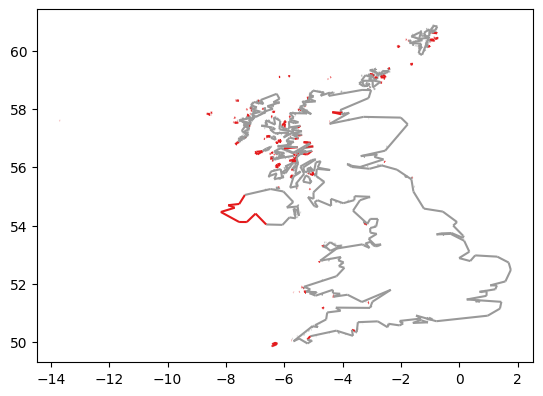

In [15]:
uk = get_country("United Kingdom")
uk['coast'] = uk.apply(lambda seg: isCoast(seg), axis=1)
uk.plot(column="coast", cmap="Set1")

<Axes: >

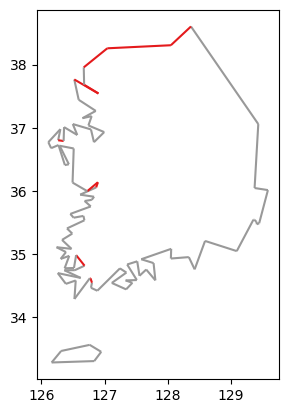

In [37]:
sk = get_country("South Korea")
sk['coast'] = sk.apply(lambda seg: isCoast(seg), axis=1)
sk.plot(column="coast", cmap="Set1")

<Axes: >

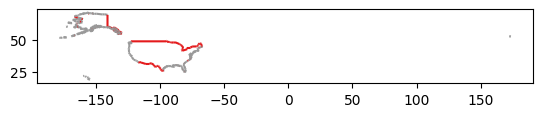

In [38]:
us = get_country("United States")
us['coast'] = us.apply(lambda seg: isCoast(seg), axis=1)
us.plot(column="coast", cmap="Set1")

In [ ]:
it = get_country("Italy")
it['coast'] = it.apply(lambda seg: isCoast(seg), axis=1)
it.plot(column="coast", cmap="Set1")

In [ ]:
it['mountain'] = it.apply(lambda seg: hasMountain(seg), axis=1)
it.plot(column="mountain", cmap="Set1")

In [ ]:
cl = get_country("Chile")
cl['mountain'] = cl.apply(lambda seg: hasMountain(seg), axis=1)
cl.plot(column="mountain", cmap="Set1")

In [ ]:
it['defensible'] = it.apply((lambda seg: seg['mountain'] or seg['coast']), axis=1)
it.plot(column="defensible", cmap="Set1")

In [ ]:
sk['mountain'] = sk.apply(lambda seg: hasMountain(seg), axis=1)
sk['defensible'] = sk.apply((lambda seg: seg['mountain'] or seg['coast']), axis=1)
sk.plot(column="defensible", cmap="Set1")

In [ ]:
cn = get_country("China")
cn['mountain'] = cn.apply(lambda seg: hasMountain(seg), axis=1)
cn['coast'] = cn.apply(lambda seg: isCoast(seg), axis=1)
cn['defensible'] = cn.apply((lambda seg: seg['mountain'] or seg['coast']), axis=1)
cn.plot(column="defensible", cmap="Set1")

In [ ]:
nk = get_country("North Korea")
nk['mountain'] = nk.apply(lambda seg: hasMountain(seg), axis=1)
nk['coast'] = nk.apply(lambda seg: isCoast(seg), axis=1)
nk['defensible'] = nk.apply((lambda seg: seg['mountain'] or seg['coast']), axis=1)
nk.plot(column="defensible", cmap="Set1")

<Axes: >

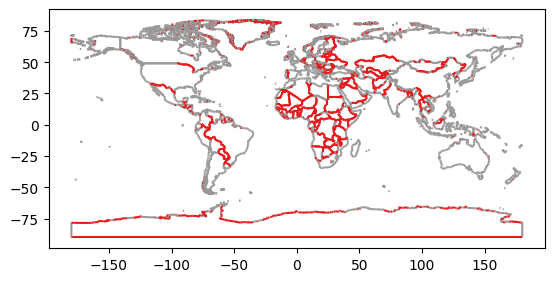

In [39]:
world = gpd.GeoDataFrame(columns=['country', 'geometry', 'coast', 'mountain', 'defensible'])
for i, country in enumerate(pol["CNTRY_NAME"].unique()):
    nu = get_country(country)
    nu['coast'] = nu.apply(lambda seg: isCoast(seg), axis=1)
    nu['mountain'] = nu.apply(lambda seg: hasMountain(seg), axis=1)
    nu['defensible'] = nu.apply((lambda seg: seg['mountain'] or seg['coast']), axis=1)
    world = pd.concat([world, nu])    

<Axes: >

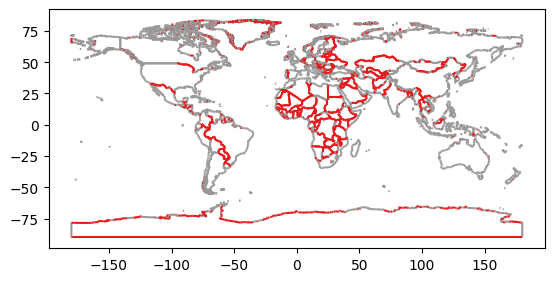

In [42]:
world.plot(column="defensible", cmap="Set1")

In [76]:
worldstats = pd.DataFrame(columns=['country', 'border_all', 'border_defensible'])

for country in world["country"].unique():
    print(country)
    seglen = 0
    defense = 0
    for i, seg in world[world['country'] == country].iterrows():
        if seg.empty or not seg['geometry']:
            break
        seglen += seg['geometry'].length
        defense += seg['geometry'].length if seg['defensible'] else 0
    nu = pd.DataFrame([[country, seglen, defense]], columns=['country', 'border_all', 'border_defensible'])
    worldstats = pd.concat([worldstats, nu])
            

Algeria
Angola
In dispute South Sudan/Sudan
Benin
Botswana
Burkina Faso
Burundi
Bouvet I.
Cameroon
Cape Verde
Central African Republic
Chad
Comoros
Egypt
Mayotte
Nigeria
Seychelles
Congo
Congo, DRC
Cote d'Ivoire


/var/folders/n0/hxq9bs5x3mlbwrd4v_dkmtd00000gn/T/ipykernel_11137/2581972847.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  worldstats = pd.concat([worldstats, nu])


Djibouti
Equatorial Guinea
Eritrea
Ethiopia
French Southern & Antarctic Lands
Gabon
Ghana
Guinea
Guinea-Bissau
Heard I. & McDonald Is.
In dispute Benin/Burkina Faso
In dispute Comoros/Mayotte/Madagascar
In dispute Djibouti/Eritrea
In dispute Egypt/Saudi Arabia
In dispute Equatorial Guinea/Gabon
Kenya
Lesotho
Liberia
Libya
Madagascar
Malawi
Mali
Mauritania
Mauritius
Morocco
Mozambique
Namibia
Niger
Rwanda
Reunion
Sao Tome & Principe
Senegal
Sierra Leone
Somalia
Tanzania
South Africa
South Sudan
Swaziland
St. Helena
The Gambia
Togo
Tunisia
Uganda
Western Sahara
Zambia
Zimbabwe
Portugal
In dispute Morocco/Spain
Afghanistan
Bangladesh
Bhutan
British Indian Ocean Territory
Myanmar
Cambodia
China
Hong Kong (China)
In dispute-Paracel Islands
In dispute Bhutan/China
In dispute China/India
In dispute China/Japan/Taiwan
In dispute India/Nepal
In dispute India/Pakistan
In dispute Japan/Russia
In dispute Japan/South Korea
India
Japan
Kazakhstan
Korean islands under UN jurisdiction
Kyrgyzstan
Laos


In [81]:
worldstats['percent_defensible'] = worldstats.apply((lambda row: row['border_defensible'] / (row['border_all'] if row['border_all'] > 0 else 1)), axis=1)
worldstats

,country,border_all,border_defensible,percent_defensible
0,Algeria,69.526292,24.793466,0.356606
0,Angola,56.482325,16.422223,0.290750
0,In dispute South Sudan/Sudan,3.619566,0.000000,0.000000
0,Benin,16.337608,1.278814,0.078274
0,Botswana,33.022343,2.147830,0.065042
...,...,...,...,...
0,In dispute Brazil/Uruguay,0.000000,0.000000,0.000000
0,Uruguay,17.635269,8.853451,0.502031
0,Venezuela,66.358664,54.183634,0.816527
0,In dispute Egypt/Sudan,6.740012,1.732106,0.256989


In [83]:
worldstats.to_csv('data/output.csv', index=False) 